In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import joblib

sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [2]:
df = pd.read_csv("crypto_ml_dataset_2000_rows.csv", parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

df.head()


,date,open_price_usd,high_price_usd,low_price_usd,close_price_usd,volume_usd,market_cap,fdv,circulating_supply,total_supply,volume_to_mcap,fdv_to_mcap,price_change_1d_pct,price_change_7d_pct,volatility_7d,rsi_14,ma_7,ma_30,sentiment_score,future_price_usd
0,2025-01-13,94559.551672,95497.579059,94200.475492,94454.770896,1.960893e+10,1.798393e+12,1.983550e+12,1.903973e+07,21000000,0.010904,1.102957,-0.110809,-3.974823,0.082514,43.927202,95760.776129,97344.648981,0.299896,94456.349375
1,2025-01-14,94454.770896,95483.393069,93814.267276,94456.349375,7.632833e+10,1.798552e+12,1.983583e+12,1.904110e+07,21000000,0.042439,1.102878,0.001671,-7.603532,0.065264,43.931714,94650.341107,97114.293605,1.000000,96574.077688
2,2025-01-15,94456.349375,98297.363060,93681.590766,96574.077688,5.124173e+10,1.839009e+12,2.028056e+12,1.904247e+07,21000000,0.027864,1.102798,2.242018,-0.389905,0.052137,49.772439,94596.338081,96842.712811,0.969634,100313.152398
3,2025-01-16,96574.077688,101108.990681,95476.463467,100313.152398,5.763732e+10,1.910347e+12,2.106576e+12,1.904384e+07,21000000,0.030171,1.102719,3.871717,5.574217,0.059008,58.076421,95352.972079,96650.680983,1.000000,100044.579268
4,2025-01-17,100313.152398,100879.574575,98905.211952,100044.579268,5.015010e+10,1.905370e+12,2.100936e+12,1.904521e+07,21000000,0.026320,1.102640,-0.267735,8.301161,0.044900,57.343076,96448.444006,96451.003178,1.000000,104160.693585


In [3]:
FEATURES = [
    "open_price_usd",
    "high_price_usd",
    "low_price_usd",
    "close_price_usd",
    "volume_usd",
    "market_cap",
    "fdv",
    "circulating_supply",
    "volume_to_mcap",
    "fdv_to_mcap",
    "price_change_1d_pct",
    "price_change_7d_pct",
    "volatility_7d",
    "rsi_14",
    "ma_7",
    "ma_30",
    "sentiment_score"
]

TARGET = "future_price_usd"

X = df[FEATURES]
y = df[TARGET]


In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (268, 17)
Validation: (34, 17)
Test: (34, 17)


In [5]:
models = {
    "Linear Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    ),
    
    "XGBoost": xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
}


In [6]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    
    preds = model.predict(X_val)
    
    results[name] = {
        "MAE": mean_absolute_error(y_val, preds),
        "RMSE": np.sqrt(mean_squared_error(y_val, preds)),
        "R2": r2_score(y_val, preds)
    }

pd.DataFrame(results).T.sort_values("RMSE")


,MAE,RMSE,R2
Random Forest,2165.654073,3123.426265,0.595559
XGBoost,2682.213406,3420.742719,0.514897
Linear Regression,3141.468320,3771.613873,0.410278


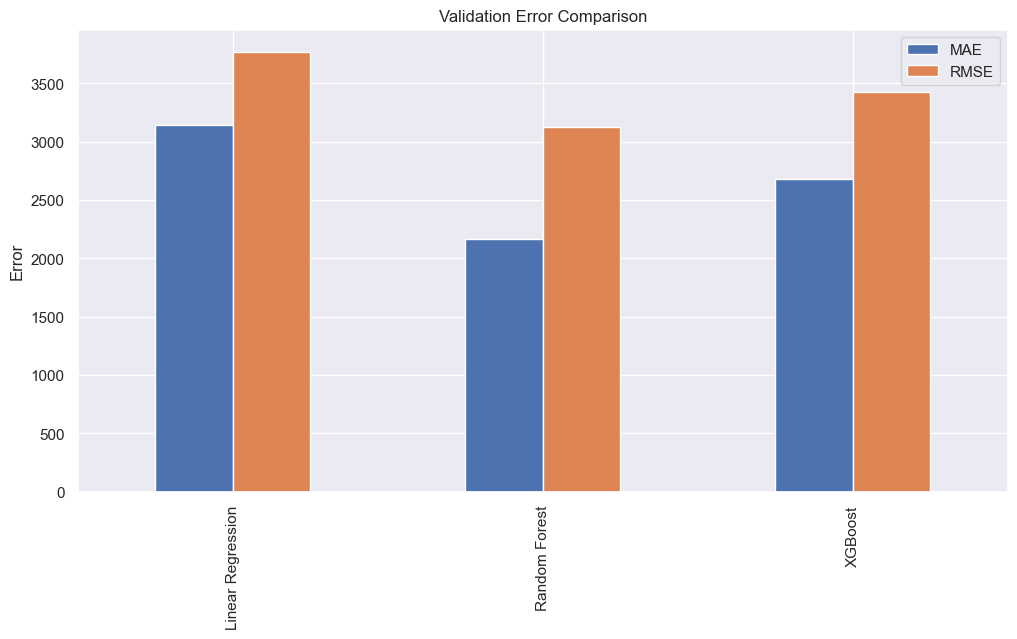

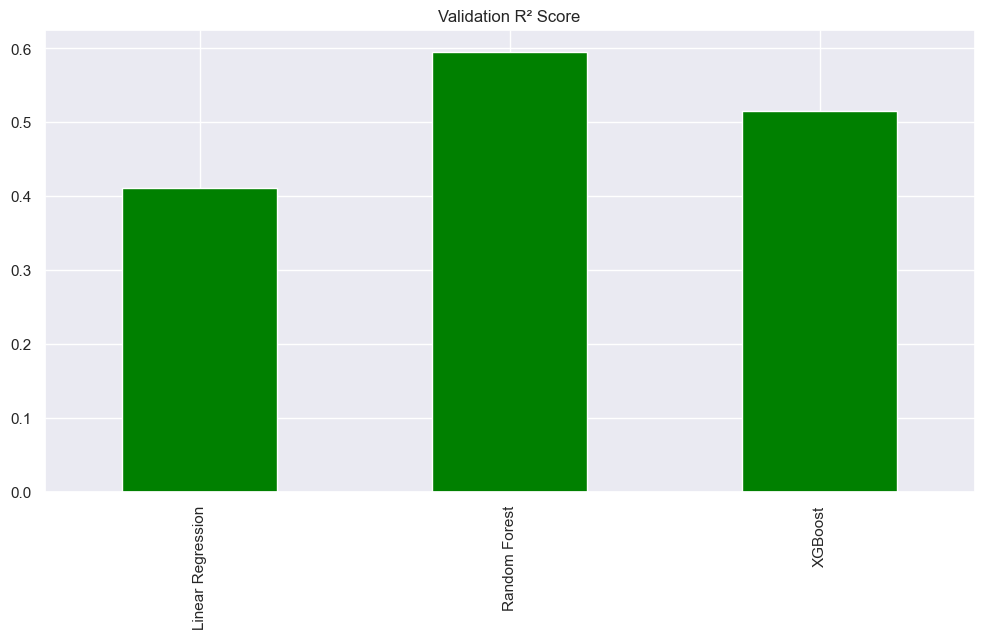

In [7]:
metrics_df = pd.DataFrame(results).T

metrics_df[["MAE", "RMSE"]].plot(kind="bar")
plt.title("Validation Error Comparison")
plt.ylabel("Error")
plt.show()

metrics_df["R2"].plot(kind="bar", color="green")
plt.title("Validation R² Score")
plt.show()


In [8]:
best_model_name = metrics_df["RMSE"].idxmin()
best_model = models[best_model_name]

print(f"✅ Best Model: {best_model_name}")


✅ Best Model: Random Forest


In [9]:
X_final = pd.concat([X_train, X_val])
y_final = pd.concat([y_train, y_val])

best_model.fit(X_final, y_final)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [10]:
test_preds = best_model.predict(X_test)

print("Test MAE:", mean_absolute_error(y_test, test_preds))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))
print("Test R2:", r2_score(y_test, test_preds))


Test MAE: 2028.1739746987814
Test RMSE: 2606.532264794852
Test R2: 0.5814366530769843


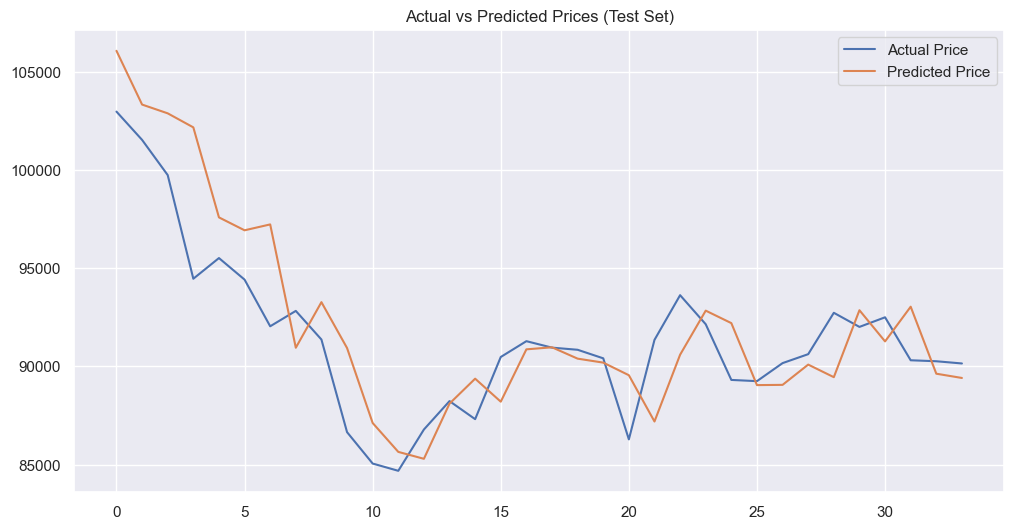

In [11]:
plt.plot(y_test.values, label="Actual Price")
plt.plot(test_preds, label="Predicted Price")
plt.legend()
plt.title("Actual vs Predicted Prices (Test Set)")
plt.show()


In [12]:
joblib.dump(best_model, "best_crypto_price_model.pkl")
print("✅ Model saved as best_crypto_price_model.pkl")


✅ Model saved as best_crypto_price_model.pkl


In [13]:
sample_1 = X_test.iloc[0].values.reshape(1, -1)
best_model.predict(sample_1)



d:\AllProjects\CoinGecko\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([106055.0432593])

In [14]:
sample_2 = X_test.iloc[10].values.reshape(1, -1)
best_model.predict(sample_2)


d:\AllProjects\CoinGecko\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([87115.65829847])

In [15]:
sample_3 = X_test.iloc[25].values.reshape(1, -1)
best_model.predict(sample_3)


d:\AllProjects\CoinGecko\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([89043.3089823])